<a href="https://colab.research.google.com/github/abhinavgairola/NLP_Timeseries/blob/main/Capstone_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#import requests
#from urllib.request import urlopen, Request
#from bs4 import BeautifulSoup

In [5]:
#url = "https://finviz.com/quote.ashx"
#def request(ticker):
#  payload = {"t":ticker,'start':'2020-01-01','end':'2020-05-01'}
#  response = requests.get(url,params=payload,headers={'user-agent':"Customer"})
#  if response.status_code == 200:
#    return response

In [6]:
#soup = BeautifulSoup(request('AMZN').text, 'html.parser')

In [7]:
#soup.find(id='news-table')

In [8]:
#! git clone https://github.com/Kriyszig/financial-news-data.git

In [9]:
#!git clone https://github.com/duynht/financial-news-dataset.git

In [10]:
#cd financial-news-data

In [11]:
#!python main.py

In [12]:
#df.to_parquet('/content/drive/My Drive/News.gzip',compression='gzip')

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
df = pd.read_parquet('/content/drive/My Drive/News.gzip')

In [15]:

df.head(10)

,Headline,Journalists,Date,Link,Article
0,Fed officials at odds on how long to keep rate...,[],"Tue Mar 2, 2010 9:35pm EST",http://www.reuters.com/article/2010/03/03/us-u...,NEW YORK (Reuters) - Top Federal Reserve offi...
1,Market finishes flat as Obama pushes regulation,[Edward Krudy],"Wed Mar 3, 2010 4:59pm EST",http://www.reuters.com/article/2010/03/03/us-m...,NEW YORK (Reuters) - U.S. stocks ended little...
2,Euro's woes mixed blessing for carmakers,"[Helen Massy-Beresford, Christiaan Hetzner]","Wed Mar 3, 2010 12:08pm EST",http://www.reuters.com/article/2010/03/03/us-a...,GENEVA (Reuters) - Global carmakers exporting...
3,Wells Fargo CEO '09 compensation more than dou...,[Elinor Comlay],"Wed Mar 3, 2010 6:44pm EST",http://www.reuters.com/article/2010/03/03/us-w...,NEW YORK (Reuters) - Wells Fargo & Co ( WFC.N...
4,Molson noncommittal on cash use,[Martinne Geller],"Wed Mar 3, 2010 6:27pm EST",http://www.reuters.com/article/2010/03/03/us-m...,NEW YORK (Reuters) - Molson Coors Brewing Co ...
5,Islamic finance must harmonize practices to grow,[Suleiman al-Khalidi],"Wed Mar 3, 2010 3:53pm EST",http://www.reuters.com/article/2010/03/03/us-i...,"SWEIMEH, Jordan, March 3 (Reuter) - Islamic ba..."
6,Fewer sellers cut home prices in Feb: Zillow,[Julie Haviv],"Wed Mar 3, 2010 8:06am EST",http://www.reuters.com/article/2010/03/03/us-u...,NEW YORK (Reuters) - The percentage of U.S. h...
7,"Austerity steps to ease, not end Greek crisis",[Andrew Torchia],"Wed Mar 3, 2010 8:57am EST",http://www.reuters.com/article/2010/03/03/us-g...,LONDON (Reuters) - Austerity steps announced ...
8,Factbox: White House draft language on Volcker...,[],"Wed Mar 3, 2010 2:17pm EST",http://www.reuters.com/article/2010/03/03/us-f...,WASHINGTON (Reuters) - The Obama administrati...
9,EU exec yet to see new Greek austerity plan,[],"Wed Mar 3, 2010 6:21am EST",http://www.reuters.com/article/2010/03/03/us-e...,BRUSSELS (Reuters) - The European Commission ...


In [16]:
Data_Article_Headline = df[['Date','Headline','Article']].sort_values(by='Date',ascending=False)

In [17]:
Data_Article_Headline['Headline'].head(5)

43749        Goldman CEO warns against regulatory overkill
43731                     Home loan demand at 3-month high
31069      Texas Instruments raises forecasts, shares rise
43720    July consumer credit falls a record $21.6 billion
43727        Bernanke's back but Obama can still shape Fed
Name: Headline, dtype: object

In [18]:
import re 
pattern = re.compile(r'[,\:,\',\"""",\;]')
Headline = []
#count = 0
for text in (Data_Article_Headline.Headline):
  text_2 = re.sub(pattern,'',text)
  Headline.append(text_2)
Data_Article_Headline['Headline_2']=Headline

### 

In [19]:
Data_Article_Headline['Headline_2'].head(5)

43749        Goldman CEO warns against regulatory overkill
43731                     Home loan demand at 3-month high
31069       Texas Instruments raises forecasts shares rise
43720    July consumer credit falls a record $21.6 billion
43727         Bernankes back but Obama can still shape Fed
Name: Headline_2, dtype: object

In [20]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_lg")
Vector = {}
for Headline in Data_Article_Headline['Headline_2']:
  doc = nlp(Headline)
  print("Translating the Headline {} and vector shape is {}".format(Headline, doc.vector.shape))
  Vector[Headline]=doc.vector
    

Streaming output truncated to the last 5000 lines.
Translating the Headline Banks saved but Europe risks losing a generation and vector shape is (300,)
Translating the Headline Italy to seek some budget flexibility at EU summit minister and vector shape is (300,)
Translating the Headline Goldman leads decline as Wall Street commodity revenues plummet and vector shape is (300,)
Translating the Headline U.S. stocks near 5-1/2-year highs oil rebounds and vector shape is (300,)
Translating the Headline SEC nominee White promises unrelenting enforcement and vector shape is (300,)
Translating the Headline Airbus sees A320neo orders sets goal for earlier model and vector shape is (300,)
Translating the Headline Merrills head of structured products for ultra-wealthy departs and vector shape is (300,)
Translating the Headline EU worried by Hungarys changes to constitution and vector shape is (300,)
Translating the Headline Analysis Solar trade war promises order bonanza for Taiwan and vector sh

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ke=list(Vector.keys())
Vector[ke[0]].shape
Vector


In [24]:
ke= list(Vector.keys())
import numpy as np
import cupy as cp

In [25]:
ke = list(Vector.keys())
for i in ke:
  Vector[i] = cp.asnumpy(Vector[i])

In [ ]:
Headlines_to_vector = pd.DataFrame(Vector)

In [27]:
Headlines_to_vector.head(5)

,Goldman CEO warns against regulatory overkill,Home loan demand at 3-month high,Texas Instruments raises forecasts shares rise,July consumer credit falls a record $21.6 billion,Bernankes back but Obama can still shape Fed,TEXT OPEC end of meeting statement,Talbots shares rise after results,QUOTEBOX OPEC agrees to keep oil output unchanged,Another financial crisis inevitable Greenspan,Kraft seeks $8 billion financing for Cadbury bid report,Barrick to sell $3 billion in stock to buy back hedges,OPEC agrees to keep output unchanged delegates,Frail-looking Steve Jobs returns to Apple stage,BofA pushes SEC settlement rejects Cuomo charges,Goldman boss says anger over pay justified,Chinas Geely eyes bid for Fords Volvo cars,Wall Street closes up S&P posts highest 09 finish,Feds Beige Book sees signs economy is improving,Fed officials see slow recovery for labor market,Saudi Arabia leads the call for no OPEC change,Global oil supplies to outstrip demand EIA,Chinas Geely eyes bid for Fords Volvo car,Home loan demand at 3-month high millions more foreclosures,Stocks advance on recovery hopes dollar weakens,BofA letter rejects charges by Cuomo,BofA SEC say execs not liable on Merrill bonuses,Treasury sees millions more foreclosures,Oil prices rise slightly as dollar weakens,Feds Evans Fed to raise rates after jobless peaks,Feds Fisher no plan in mind for velocity of rate hikes,Kraft plays down talk of higher Cadbury bid,Talbots posts narrower-than-expected loss,McDonalds same-store sales rise 2.2 percent,Oil at $70-$75 fine for all OPEC president,U.S. and U.K. Aaa ratings safe for now Moodys,Palm unveils Pixi phone may be overshadowed by rivals,Obama U.S. cant afford to extend tax cuts for rich,BP points fingers in oil spill blame game,Hurds Oracle hire package worth millions,BP happy to talk to Russian firms about asset sales,...,Nasdaq ICE bid to snatch NYSE from Germans,CEOs rancor may mark Nasdaq battle for NYSE,Japan plans to bail out stricken nuclear plant,Factbox Listing fees a tiny part of U.S. IPO cost,Ford increases CEOs pay 48 percent to $26.5 million,World factories buoyant as price pressures rising,Feds Dudley warns of over-optimism counters hawks,Barry Callebaut unfazed by Ivory Coast cocoa fears,Crisis-hit Portugal buys some time with bond sale,TPG sells 4.5 percent stake to sovereign funds source,Gas-sipping cars drive March sales gain,Icahn Dish bid for Blockbuster assets report,Analysis NYSE trading one regulatory headache for another,Stocks roar as Q2 begins euro oil up too,Far from quake Toyota Citys suppliers on life support,American Apparel says it may file for bankruptcy,Employers step up hiring jobless rate drops,Analysis Growth in temp jobs hints at wider recovery,Few U.S. traders pledge allegiance to Nasdaqs NYSE bid,Nasdaq sees scale but companies worry about choice,Busy China and India factories keep inflation aloft,Fitch says Portugal needs bailout while S&P cuts Ireland,Boeing Turkish Airlines sign order for 15 planes,Paulson at $4.9 billion tops hedge fund earner list,Feds Dudley would be surprised if QE2 uncompleted,Nasdaq and ICE confident on financing NYSE bid source,Report critical of pay practices at Fannie Mae Freddie Mac,Morgan Stanley Goldman to recommend say on pay report,Toyota earnings hit but priority is Japan recovery,EU files tactical appeal in Boeing trade spat,Feds Dudley sees no reason to reverse course,S&P cuts Ireland Fitch in downgrade threat,Manufacturing growth slows prices jump,Feds Plosser raising rates in 2011 a possibility,Analysis Where are those jobs? Bars and hospitals,Instant View Employment jumps jobless rate falls,White House Jobs data shows improving economy,Instant View Nasdaq ICE make rival bid for NYSE Euronext,Instant View Factory activity growth steady in March,Ireland put on credit watch negative by Fitch
0,-0.514145,-0.493392,-0.400243,-0.324121,-0.040907,0.009625,-0.159365,-0.031836,-0.418837,-0.310383,-0.131126,0.128235,-0.075897,-0.341810,-0.635923,0.182642,-0.042

In [28]:
Headlines_to_vector_transposed = Headlines_to_vector.T

In [ ]:
Data_Article_Headline[Data_Article_Headline.Headline.str.contains('Goldman')].sort_values(by='Date')

In [30]:
Headlines_to_vector.to_numpy()

array([[-0.51414496, -0.49339166, -0.40024266, ...,  0.02973291,
         0.00223434, -0.3594976 ],
       [ 0.17452198,  0.27698   ,  0.35676786, ..., -0.1275007 ,
         0.34336877,  0.16623664],
       [ 0.05684367, -0.06949583,  0.0318045 , ..., -0.0192307 ,
         0.00139462, -0.24106263],
       ...,
       [ 0.05386165, -0.22550501, -0.40018198, ..., -0.26053688,
         0.05911237, -0.01042075],
       [-0.02591332,  0.016601  ,  0.18241817, ..., -0.057705  ,
        -0.1456455 , -0.17169337],
       [ 0.06801099, -0.05191733, -0.07230403, ...,  0.309778  ,
         0.15916689,  0.17444113]], dtype=float32)

This is cluster2
This is cluster3
This is cluster4
This is cluster5
This is cluster6
This is cluster7
This is cluster8
This is cluster9
This is cluster10
This is cluster11
This is cluster12
This is cluster13
This is cluster14
This is cluster15
This is cluster16
This is cluster17
This is cluster18
This is cluster19
This is cluster20
This is cluster21
This is cluster22
This is cluster23
This is cluster24
This is cluster25
This is cluster26
This is cluster27
This is cluster28
This is cluster29
This is cluster30
This is cluster31
This is cluster32
This is cluster33
This is cluster34
This is cluster35
This is cluster36


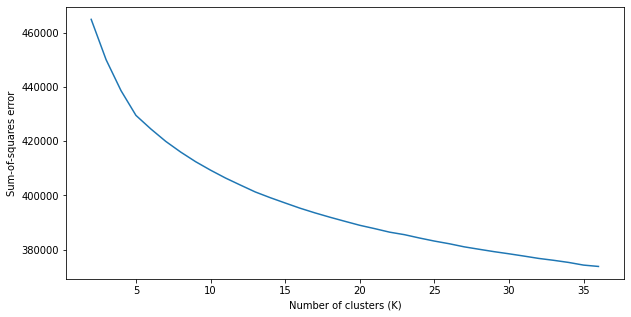

In [31]:
from sklearn.cluster import KMeans
import numpy as np
x_cols = Headlines_to_vector_transposed.to_numpy()
S =[]
cluster_assignment = {}
for k in range(2,37):
    print("This is cluster{}".format(k))
    model = KMeans(n_clusters=k)
    fitted = model.fit(x_cols)
    predict = fitted.predict(x_cols)## points belonging to which cluster
    centers = model.cluster_centers_
    center_cluster = centers[predict]## To which cluster center belongs too
    S.append(np.sum((x_cols-center_cluster)**2))## Get the SS for the current value of 'k'
    cluster_assignment[str(k)]=predict
plt.figure(figsize=(10,5))
plt.plot(range(2,37),S)
plt.ylabel(r'Sum-of-squares error')
plt.xlabel(r'Number of clusters (K)')
plt.show()

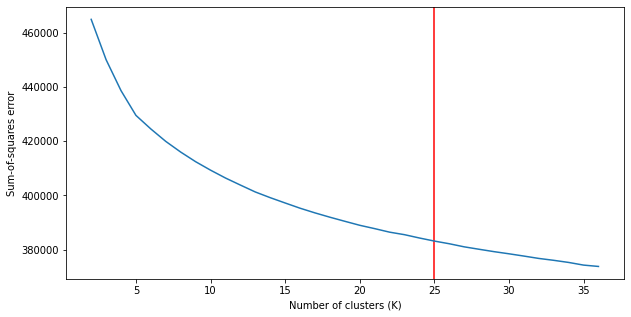

In [32]:
plt.figure(figsize=(10,5))
plt.axvline(25,color='red')
plt.plot(range(2,len(S)+2),S)
plt.ylabel(r'Sum-of-squares error')
plt.xlabel(r'Number of clusters (K)')
plt.show()

In [54]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(x_cols)
kmeans = KMeans(n_clusters=10)
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

In [85]:
result = zip(kmeans.labels_,Headlines_to_vector_transposed.index )

In [46]:
ABC = list(result)

In [47]:
ABC[0][0].shape

(300,)

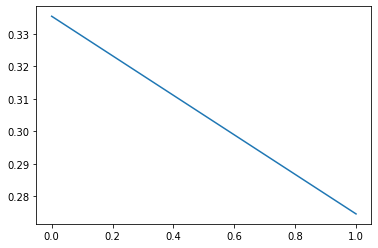

In [55]:
plt.plot(sklearn_pca.explained_variance_)

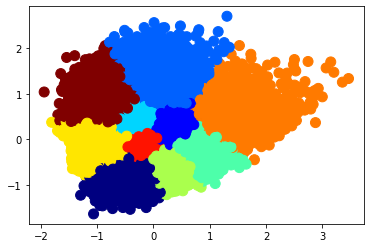

In [56]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=100, cmap='jet')

In [64]:
DataFrame = pd.DataFrame({'label':kmeans.labels_,'sent':list(Vector.keys())})

In [89]:
DataFrame[DataFrame['label']==7]

,label,sent
0,7,Goldman CEO warns against regulatory overkill
13,7,BofA pushes SEC settlement rejects Cuomo charges
15,7,Chinas Geely eyes bid for Fords Volvo cars
21,7,Chinas Geely eyes bid for Fords Volvo car
24,7,BofA letter rejects charges by Cuomo
...,...,...
98103,7,RBS Fortis Santander eye break-up bid for ABN
98154,7,JC Penney hires Blackstone Ackman willing to p...
98217,7,S&P places Boeing on CreditWatch
98229,7,Sokol affair credit negative for Berkshire Moodys


In [86]:
DataFrame_2 = pd.DataFrame(dict(result),index=[0])

In [88]:
DataFrame_2.melt()

,variable,value
0,7,CEOs rancor may mark Nasdaq battle for NYSE
1,6,Instant View Factory activity growth steady in...
2,9,Instant View Employment jumps jobless rate falls
3,0,Analysis Where are those jobs? Bars and hospitals
4,5,Ireland put on credit watch negative by Fitch
5,3,Stocks roar as Q2 begins euro oil up too
6,1,Instant View Nasdaq ICE make rival bid for NYS...
7,2,Paulson at $4.9 billion tops hedge fund earner...
8,8,Feds Plosser raising rates in 2011 a possibility
9,4,EU files tactical appeal in Boeing trade spat
